# Anxiety vs Depression

In [101]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [79]:
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [80]:
state_df = pd.read_pickle("ls_data/state_all.df")
phq_df = pd.read_pickle("ls_data/phq_0_16.df")

spin_fill_df = pd.read_pickle("ls_data/jama_data/all_state_shift_no_imp.df")
shift_df = pd.read_pickle("ls_data/jama_data/all_phq_shift_imp.df")

In [81]:
all_inv_df = spin_fill_df[['pid', 'study_wk', 'survey_idx', 'baseline_cluster', 'gad_total', 'spin_total']].copy()

In [82]:
all_inv_df = all_inv_df.merge(shift_df[['pid', 'study_wk', 'phq_total_sc']], on=['pid', 'study_wk'], how='left')

## Across participant correlations

- each weekly check-in for each participant is considered iid

In [83]:
target_cols = ['gad_total', 'spin_total', 'phq_total_sc']
all_inv_df['gad_total'] = all_inv_df['gad_total'].astype(float)

In [84]:
all_inv_df = all_inv_df.dropna(subset=['gad_total', 'phq_total_sc'], axis='rows')

In [93]:
pg.pairwise_corr(all_inv_df, columns=target_cols, padjust='fdr_bh')[['X', 'Y', 'method', 'tail', 'n', 'r', 'p-unc', 'p-corr', 'p-adjust']]

,X,Y,method,tail,n,r,p-unc,p-corr,p-adjust
0,gad_total,spin_total,pearson,two-sided,1285,0.547,2.514752e-101,3.772128e-101,fdr_bh
1,gad_total,phq_total_sc,pearson,two-sided,1287,0.706,4.231315e-195,1.269394e-194,fdr_bh
2,spin_total,phq_total_sc,pearson,two-sided,1285,0.471,7.619783e-72,7.619783e-72,fdr_bh


## Within participant correlations: repeated measures correlation (rm_corr)

- ANCOVA adjustment for inter-individual variability
- Provides best linear fit per participant with parallel regression lines
- [paper reference](https://www.frontiersin.org/articles/10.3389/fpsyg.2017.00456/full)

In [86]:
# remove individuals with only one reading or 0 variance between readings
all_inv_df = all_inv_df[~all_inv_df['pid'].isin(['14196469', '29584096', '70483015', '70027963', '81720300'])]

In [90]:
with warnings.catch_warnings(record=True):
    print("repeated measures correlation for GAD vs PHQ")
    display(pg.rm_corr(data=all_inv_df, x='gad_total', y='phq_total_sc', subject='pid'))

repeated measures correlation for GAD vs PHQ


,r,dof,pval,CI95%,power
rm_corr,0.331,1026,1.092773e-27,"[0.28, 0.38]",1.0


In [94]:
with warnings.catch_warnings(record=True):
    print("repeated measures correlation for SPIN vs PHQ")
    display(pg.rm_corr(data=all_inv_df, x='spin_total', y='phq_total_sc', subject='pid'))

repeated measures correlation for SPIN vs PHQ


,r,dof,pval,CI95%,power
rm_corr,0.087,1024,0.005408,"[0.03, 0.15]",0.795


In [96]:
with warnings.catch_warnings(record=True):
    print("repeated measures correlation for GAD vs SPIN")
    display(pg.rm_corr(data=all_inv_df, x='gad_total', y='spin_total', subject='pid'))

repeated measures correlation for GAD vs SPIN


,r,dof,pval,CI95%,power
rm_corr,0.184,1024,2.876501e-09,"[0.12, 0.24]",1.0


In [102]:
pids = all_inv_df['pid'].unique()
np.random.seed(0)
sel_pids = np.random.choice(pids, 75)

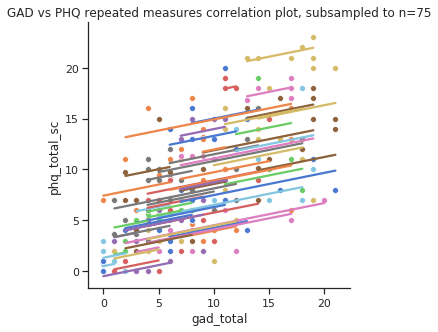

In [126]:
sel_df = all_inv_df[all_inv_df['pid'].isin(sel_pids)]
alpha = 0.3
x_jitters = [ 2 for i in range(pids.shape[0])]
y_jitters = [ 2 for i in range(pids.shape[0])]

pg.plot_rm_corr(data=sel_df, x='gad_total', y='phq_total_sc', subject='pid', 
                kwargs_facetgrid={
                    'height': 4.5, 
                    'aspect': 1,
                    'palette':'muted',
                    'hue_kws': {
                        'x_jitter': x_jitters,
                        'y_jitter': y_jitters
                    }})
plt.title("GAD vs PHQ repeated measures correlation plot, subsampled to n=75");

**Notes**

- across individual correlation considers all points, while within-individual correlations considers the slope of each within-individual regression line